In [22]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import time
import seaborn as sns
from scipy import interpolate
from scipy.stats import norm
import random
import imageio
import glob
import itertools
import pickle
import os
from line_profiler import LineProfiler
from scipy.spatial import distance_matrix


# Import classes
from field_SINMOD import field_SINMOD
from WGS import WGS
from field_operation import FieldOperation
from AUV_data import AUVData
from DescicionRule import DescicionRule

In [23]:
SIGMA = 2
def corr_d(d):
    # This takes about 6s for 1.000.000
    a = 100
    return SIGMA**2 * np.exp(-(d/a)**2)

def make_covariance_matrix(X):
    D = distance_matrix(X,X)
    return corr_d(D)

def make_covariance_matrix_2(X_1, X_2):
    D = distance_matrix(X_1,X_2)
    return corr_d(D)

def update_covariance_matrix(old_cov_matrix,points_old, points_new):
    n = len(points_old)
    m = len(points_new)
    
    new_covariance_matrix = np.zeros((n+m,n+m))
    new_covariance_matrix[0:n,0:n] = old_cov_matrix
    
    covariance_matrix_ab = make_covariance_matrix_2(points_old, points_new)
    covariance_matrix_ba = np.transpose(covariance_matrix_ab)
    
    covariance_matrix_bb = make_covariance_matrix(points_new)
    
    new_covariance_matrix[n:(n+m),0:n] = covariance_matrix_ba
    new_covariance_matrix[0:n,n:(n+m)] = covariance_matrix_ab
    
    new_covariance_matrix[(n):(n+m),(n):(n+m)] = covariance_matrix_bb
    
    return new_covariance_matrix

In [50]:
def inverse_matrix_block_symetric(A, B, D, A_inv):
    # inverting a matrix with the block shape 
    # | A   B | 
    # | B^T C |
    # where A^-1 is already calculated

    n = A.shape[0]
    m = D.shape[0]
    inverted_matrix = np.zeros((n+m,n+m))

    #C_inv = np.linalg.inv(C)
    U = B.T @ A_inv
    V = A_inv @ B
    print(np.sum(U - V.T))
    print(np.sum(V))
    S = np.linalg.inv(D - B.T @ A_inv @ B)

    inverted_matrix[0:n,0:n] = A_inv + A_inv @ B @ np.linalg.inv(D - B.T @ A_inv @ B) @ B.T @ A_inv
    inverted_matrix[n:(n+m),0:n] = - np.linalg.inv(D - B.T @ A_inv @ B) @ B.T @ A_inv
    inverted_matrix[0:n,n:(n+m)] = - A_inv @ B @ np.linalg.inv(D - B.T @ A_inv @ B)
    inverted_matrix[(n):(n+m),(n):(n+m)] = np.linalg.inv(D - B.T @ A_inv @ B)

    return inverted_matrix

In [112]:
def inverse_matrix_block_symetric(A, B, D, A_inv):
    # inverting a matrix with the block shape 
    # | A   B | 
    # | B^T C |
    # where A^-1 is already calculated

    n = A.shape[0]
    m = D.shape[0]
    inverted_matrix = np.zeros((n+m,n+m))

    #C_inv = np.linalg.inv(C)
    U = B.T @ A_inv
    V = U.T #A_inv @ B
    #print(np.sum(U - V.T))
    #print(np.sum(V))

   

    S = np.linalg.inv(D - B.T @ A_inv @ B)
    
    V_at_S = V @ S

    #print(np.sum(V_at_S.T - S @ U))

    inverted_matrix[0:n,0:n] = A_inv + V_at_S @ U
    inverted_matrix[n:(n+m),0:n] = - S @ U
    inverted_matrix[0:n,n:(n+m)] = - V_at_S
    inverted_matrix[(n):(n+m),(n):(n+m)] = S

    return inverted_matrix

In [25]:
def inverse_matrix_block_symetric_2(A, B, D, A_inv):
    # inverting a matrix with the block shape 
    # | A   B | 
    # | B^T C |
    # where A^-1 is already calculated

    n = A.shape[0]
    m = B.shape[0]
    inverted_matrix = np.zeros((n+m,n+m))

    C_inv = np.linalg.inv(C)
    U = B.T @ A_inv
    S = np.linalg.inv(A - B @ C_inv @ B.T)

    inverted_matrix[0:n,0:n] = S
    inverted_matrix[n:(n+m),0:n] = - S @ U
    inverted_matrix[0:n,n:(n+m)] = inverted_matrix[n:(n+m),0:n].T
    inverted_matrix[(n):(n+m),(n):(n+m)] = S

    return inverted_matrix

In [26]:
def inverse_matrix_block(A, B, C, D, A_inv):
    # inverting a matrix with the block shape 
    # | A   B | 
    # | B^T C |
    # where A^-1 is already calculated

    n = A.shape[0]
    m = C.shape[0]
    inverted_matrix = np.zeros((n+m,n+m))

    U = B.T @ A_inv
    S = np.linalg.inv(D - C @ A_inv @ B)

    
    print(inverted_matrix[0:n,0:n].shape)
    print(inverted_matrix[n:(n+m),0:n].shape)
    print(inverted_matrix[0:n,n:(n+m)].shape)
    print(inverted_matrix[(n):(n+m),(n):(n+m)].shape)

    inverted_matrix[0:n,0:n] = A_inv + A_inv @ B @ S @ C @  A_inv
    inverted_matrix[n:(n+m),0:n] = - S @ C @ A_inv
    inverted_matrix[0:n,n:(n+m)] = - A_inv @ B @ (D - C @ A_inv @ B)
    inverted_matrix[(n):(n+m),(n):(n+m)] = S

    return inverted_matrix

In [27]:
A = np.arange(36).reshape(6,6)
print(A)
print(A[0:4,0:4])
print(A[0:4,4:6])
print(A[4:6,0:4])
print(A[4:6,4:6])

[[ 0  1  2  3  4  5]
 [ 6  7  8  9 10 11]
 [12 13 14 15 16 17]
 [18 19 20 21 22 23]
 [24 25 26 27 28 29]
 [30 31 32 33 34 35]]
[[ 0  1  2  3]
 [ 6  7  8  9]
 [12 13 14 15]
 [18 19 20 21]]
[[ 4  5]
 [10 11]
 [16 17]
 [22 23]]
[[24 25 26 27]
 [30 31 32 33]]
[[28 29]
 [34 35]]


In [54]:
a = np.array([0,0])
b = np.array([1000,1000])
c = np.array([1001,1001])
d = np.array([1100,1100])
n, m = 500, 400
S = np.linspace(a,b , n+m)
S = np.random.rand(n + m,2) * 100
S1 = S[0:n]
S2 = S[n:n+m]


T_1 = np.eye(n) * 0.4**2
T_2 = np.eye(m) * 0.4**2
T = np.eye(n+m) * 0.4**2

Sigma_11 = make_covariance_matrix(S1)
Sigma_12 = make_covariance_matrix_2(S1,S2)
Sigma_21 = Sigma_12.T
Sigma_22 = make_covariance_matrix(S2)

Sigma = make_covariance_matrix(S)
Sigma_a = update_covariance_matrix(Sigma_11, S1, S2)
np.sum(Sigma- Sigma_a)


0.0

In [29]:
print(np.sum(Sigma_12 - Sigma[0:n, n:n+m]))

0.0


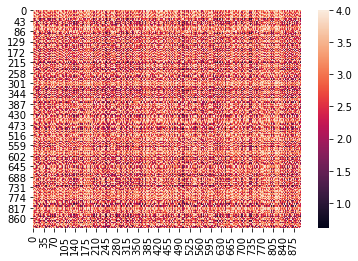

In [30]:
if n + m < 1000:
    sns.heatmap(Sigma)

In [31]:
Sigma_11_inv = np.linalg.inv(Sigma_11 + T_1)

In [32]:
Sigma_LL = np.zeros((n+m,n+m))

Sigma_LL[0:n,0:n] = Sigma_11 + T_1
Sigma_LL[n:(n+m),0:n] = Sigma_21
Sigma_LL[0:n,n:(n+m)] = Sigma_12
Sigma_LL[(n):(n+m),(n):(n+m)] = Sigma_22 + T_2

print(np.sum(Sigma + T - Sigma_LL))


0.0


In [57]:
t1 = time.time()
Sigma_inv_1 = np.linalg.inv(Sigma + T)
t2 = time.time()
print(t2 - t1)

t1 = time.time()
Sigma_inv_2 = np.linalg.inv(Sigma + T)
t2 = time.time()
print(t2 - t1)

np.sum(Sigma_inv_1- Sigma_inv_2)

0.12185788154602051
0.03726005554199219


0.0

In [58]:
Sigma_11_inv = np.linalg.inv(Sigma_11 + T_1)
Sigma_22_inv = np.linalg.inv(Sigma_22 + T_2)

In [62]:
t1 = time.time()
Sigma_inv_alt = inverse_matrix_block_symetric(Sigma_11 + T_1, Sigma_12, Sigma_22 + T_2, Sigma_11_inv)
t2 = time.time()
print(t2 - t1)


np.sum(np.abs(Sigma_inv_1 - Sigma_inv_alt))

-4.581696133598712e-12
399.8428263222219
0.17667794227600098


3.986693989762219e-06

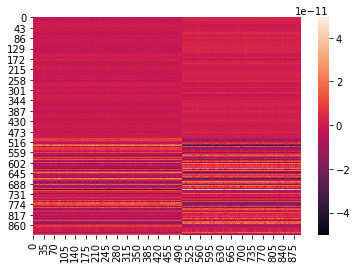

In [64]:
if n + m < 1000:
    sns.heatmap(Sigma_inv_1 - Sigma_inv_alt)

In [37]:
print(np.sum(np.diag(Sigma_inv_alt @ (Sigma + T))) - (n + m))

-3.651621227618307e-10


In [38]:
print(np.sum(np.diag(Sigma_inv_1 @ (Sigma + T)))- (n + m))

-4.547473508864641e-13


In [1]:
m = 200
n = 40
a = np.array([0,0])
b = np.array([n*m,n*m])
S = np.linspace(a,b , n*m)
S = S + np.random.normal(0,0.2,S.shape)
#S = np.random.rand(n * m,2) * 2000
S1 = S[0:n]
S2 = S[n:n+m]

tau = 0.4

Sigma = make_covariance_matrix(S[0:m])
Sigma_11_inv = np.linalg.inv(Sigma + np.eye(m) * tau**2)

j = 0

error_list = []
error_ni_list = []

max_error_list = []
max_error_ni_list = []

Time_1 = []
Time_2 = []
Time_3 = []
for i in range(1, n - 1):

    S1 = S[0:m*i]
    S2 = S[m*i : m * (i+1)]
    #print(S1.shape, S2.shape)
    Sigma_11 = make_covariance_matrix(S1)
    Sigma_12 = make_covariance_matrix_2(S1,S2)
    Sigma_21 = Sigma_12.T
    Sigma_22 = make_covariance_matrix(S2)

    Sigma = update_covariance_matrix(Sigma_11, S1, S2)

    T1 = np.eye(m*i) * tau**2
    T2 = np.eye(m) * tau**2

    t1 = time.time()
    Sigma_11_inv = inverse_matrix_block_symetric(Sigma_11 + T1, Sigma_12, Sigma_22 + T2, Sigma_11_inv)
    t2 = time.time()
    Sigma_11_ni = inverse_matrix_block_symetric(Sigma_11 + T1, Sigma_12, Sigma_22 + T2, np.linalg.inv(Sigma_11 + T1))
    t3 = time.time()
    Sigma_11_alt = np.linalg.inv(Sigma + np.eye(m * (i+1)) * tau**2 )
    t4 = time.time()

    Time_1.append(t2 - t1)
    Time_2.append(t3 - t2)
    Time_3.append(t4 - t3)

    error = np.sum(np.abs(Sigma_11_inv - Sigma_11_alt))
    error_ni =  np.sum(np.abs(Sigma_11_ni - Sigma_11_alt))
    max_error = np.max( np.abs(Sigma_11_inv - Sigma_11_alt))
    max_error_ni = np.max( np.abs(Sigma_11_ni - Sigma_11_alt))

    print(i, end=" ")
  
    if  j % (5) == 0:
        if Sigma_11_inv.shape[0] < 2000:
            sns.heatmap(np.abs(Sigma_11_inv - Sigma_11_alt), vmin = 0)
            plt.show()
        print("")
        print(f"Sum Error {error:,.2}")
        print(f"Sum error not iterative: {error_ni:,.2}" )

        print(f"Max Error {max_error:,.2}")
        print(f"Max Error not iterative {max_error_ni:,.2}")


    j += 1

    error_list.append(error)
    error_ni_list.append(error_ni)
    max_error_list.append(max_error)
    max_error_ni_list.append(max_error_ni)

plt.plot(error_list , label = "error")
plt.plot(error_ni_list, label = "error ni")
plt.legend()
plt.show()

plt.plot(max_error_list)
plt.plot(max_error_ni_list)
plt.show()

plt.plot(Time_1, label="Block update iterative")
plt.plot(Time_2, label="Block update not-iterative")
plt.plot(Time_3, label="normal update")
plt.legend()
plt.ylabel("Seconds")
plt.show()

    

NameError: name 'np' is not defined

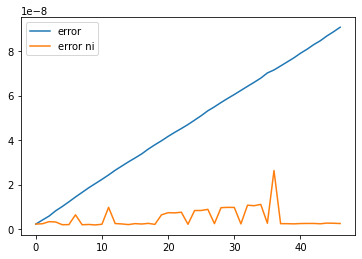

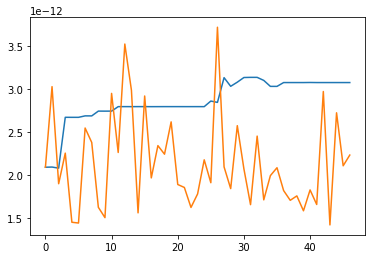

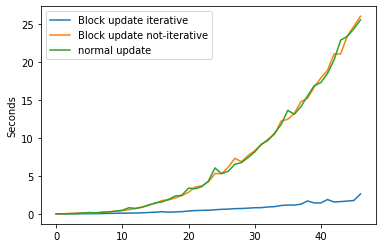

In [120]:
plt.plot(error_list , label = "error")
plt.plot(error_ni_list, label = "error ni")
plt.legend()
plt.show()

plt.plot(max_error_list)
plt.plot(max_error_ni_list)
plt.show()

plt.plot(Time_1, label="Block update iterative")
plt.plot(Time_2, label="Block update not-iterative")
plt.plot(Time_3, label="normal update")
plt.legend()
plt.ylabel("Seconds")
plt.show()